# Import Libraries

In [6]:
import pandas as pd  # For data manipulation and analysis
import spacy  # For natural language processing tasks
import re  # For regular expressions
import matplotlib.pyplot as plt  # For plotting
from wordcloud import WordCloud  # For generating word clouds
from collections import Counter  # For counting word frequencies
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization
from sklearn.cluster import KMeans  # For K-means clustering
from sklearn.decomposition import PCA  # For principal component analysis
from yellowbrick.cluster import KElbowVisualizer  # For finding the optimal number of clusters
from keybert import KeyBERT  # For keyword extraction and clustering

# Preprocessing

In [52]:
# Load the dataset from the provided URL
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Abstracts_personalized.csv')

In [9]:
# Load the spaCy English language model
nlp = spacy.load('en_core_web_sm')

# Define a function to preprocess text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Process the text using spaCy
    doc = nlp(text)
    
    # Extract words based on certain criteria
    words = [token.text for token in doc if 
                len(token) > 2 and                 # Filter out short tokens
                token.pos_ not in ['VERB', 'ADJ', "GPE", "ADP", "NUM", "AUX", "ADV"] and  # Filter out specific parts of speech
                token.lemma_ and                  # Ensure the token has a lemma
                not token.is_stop and             # Filter out stop words
                not token.is_digit and            # Filter out digits
                not token.is_currency and         # Filter out currency symbols
                not token.is_space                # Filter out spaces
            ]
    
    # Join the selected words into a single string
    return ' '.join(words)


In [10]:
# Assigning to another variable for next purpose
df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']

In [11]:
display(data.head())

0    paper presents implementation body exergame ex...
1    thinking attention education researchers pract...
2    work gamification applications evidence litera...
3    assessment method impairment individuals disea...
4    machine algorithms set examples labelling proc...
Name: Abstrak, dtype: object

In [12]:
# Define a function to extract keywords from a sentence
def extract_keywords(sentence):
    # Process the sentence using spaCy
    doc = nlp(sentence)
    
    # Extract keywords (lemmatized words) from the processed sentence
    keywords = [str(token.text.lower()) for token in doc if token.lemma_]
    return keywords

# Initialize an empty array to store keywords
keywords_array = []

# Iterate through each row in the DataFrame
for _, row in df.iterrows():
    # Get the abstract from the current row
    sentence = row['Abstrak']
    
    # Extract keywords from the abstract
    keywords = extract_keywords(sentence)
    
    # Extend the keywords_array with the extracted keywords
    keywords_array.extend(keywords)

# Create a DataFrame containing unique keywords
keywords_list = pd.DataFrame(list(set(keywords_array)))

# Count the frequency of each keyword in the abstracts
abstract_count = Counter(keywords_array)

# Create a dictionary of keywords and their corresponding frequencies, filtering out duplicates
result_dict = {key: abstract_count[key] for key in keywords_array if key in abstract_count}

# Sort the result dictionary by frequency and then alphabetically
sorted_result = dict(sorted(result_dict.items(), key=lambda item: (item[1], item[0])))

In [13]:
keywords_list

,0
0,majority
1,end
2,predictor
3,size
4,liaison
...,...
2095,touchscreen
2096,refinement
2097,applicant
2098,sna


In [16]:
# Reload the data with the same preprocessing before clustering
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Abstracts_personalized.csv')

nlp = spacy.load('en_core_web_sm') 

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.text for token in doc if 
                len(token) > 2 and
                token.pos_ not in ['VERB', 'ADJ', "GPE", "ADP", "NUM", "AUX", "ADV"] and
                token.lemma_ and 
                not token.is_stop and
                not token.is_digit and 
                not token.is_currency and 
                not token.is_space
            ]
    return ' '.join(words)

df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']

# K-Means Clustering

[0.01875499 0.01745436]


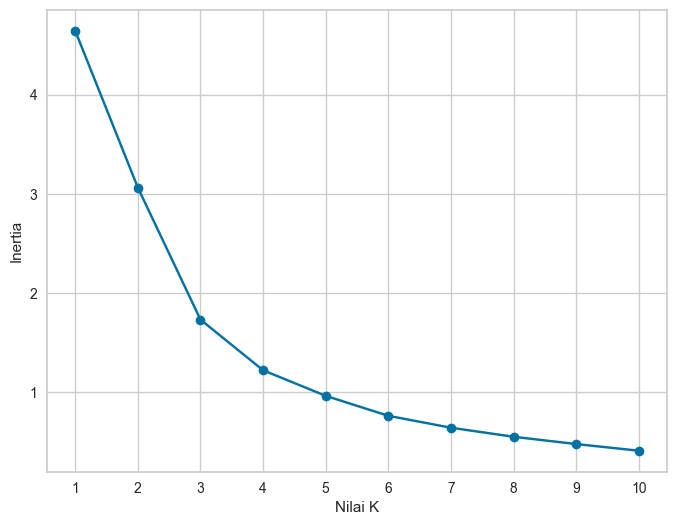

In [17]:
# Initialize a TF-IDF vectorizer with a maximum number of features equal to the number of unique keywords
vectorizer = TfidfVectorizer(max_features=len(keywords_list))

# Transform the abstracts into TF-IDF features
X = vectorizer.fit_transform(df['Abstrak'])

# Initialize PCA (Principal Component Analysis) with 2 components for dimensionality reduction
pca = PCA(n_components=2)

# Apply PCA to the TF-IDF features
X_pca = pca.fit_transform(X.toarray())

# Get the explained variance ratio of the PCA components
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

# Define a range of candidate cluster numbers (K-values)
num_clusters_range = range(1, 11)
inertia_values = []

# Iterate through the candidate cluster numbers
for num_clusters in num_clusters_range:
    # Initialize K-Means clustering with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    # Fit K-Means to the PCA-transformed data
    kmeans.fit(X_pca)
    
    # Append the inertia (within-cluster sum of squares) to the list
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow curve to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('K-numbers')
plt.ylabel('Inertia')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

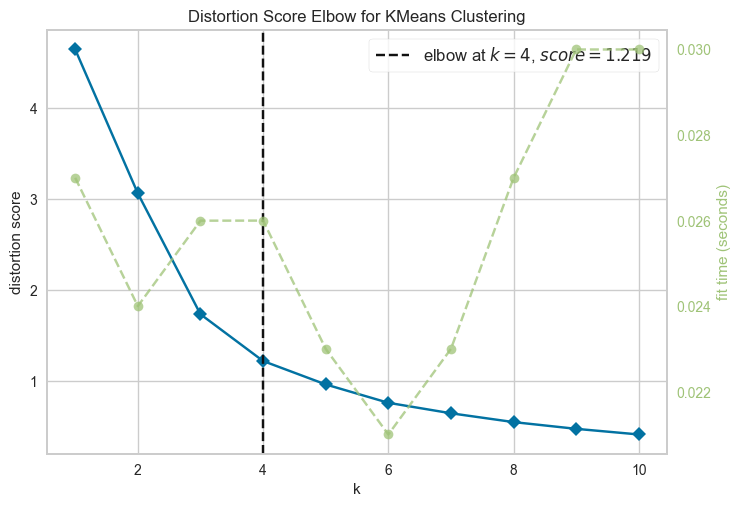

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Create a K-Means clustering model
model = KMeans()

# Create a KElbowVisualizer, which is used to visualize the elbow method
visualizer = KElbowVisualizer(model, k=(1, 11))

# Fit the visualizer on the PCA-transformed data to find the optimal number of clusters (K)
visualizer.fit(X_pca)

# Display the elbow plot with different values of K and their corresponding within-cluster sum of squares
visualizer.show()

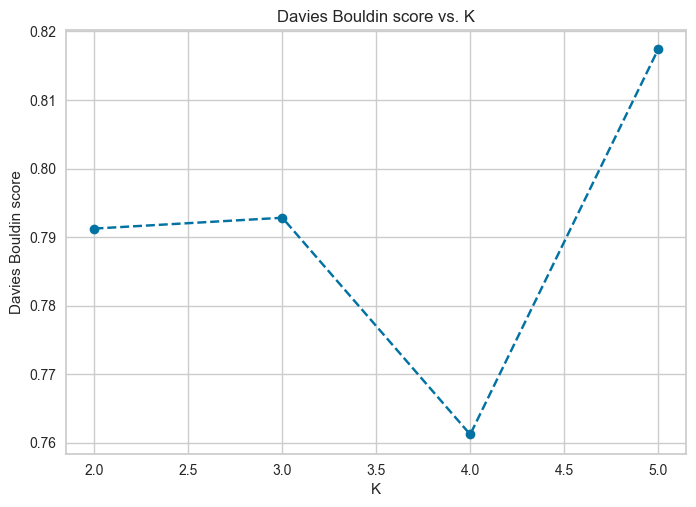

In [19]:
# Import the Davies Bouldin score function from scikit-learn
from sklearn.metrics import davies_bouldin_score

# Define a function to calculate the Davies Bouldin score for K-Means clustering
def get_kmeans_score(data, center):
    # Create a K-Means clustering model with the specified number of clusters
    kmeans = KMeans(n_clusters=center)
    
    # Fit the model and predict cluster labels
    model = kmeans.fit_predict(data)
    
    # Calculate the Davies Bouldin score, which measures the average similarity-to-dissimilarity ratio
    score = davies_bouldin_score(data, model)
    
    return score

# Perform PCA on the data to reduce dimensionality before clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

# Initialize empty lists to store scores and a range of cluster centers (K values)
scores = []
centers = list(range(2, 6))

# Iterate through different numbers of clusters (K values)
for center in centers:
    # Calculate and store the Davies Bouldin score for each K
    scores.append(get_kmeans_score(X_pca, center))

# Plot the Davies Bouldin scores against the number of clusters (K)
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')
plt.show()

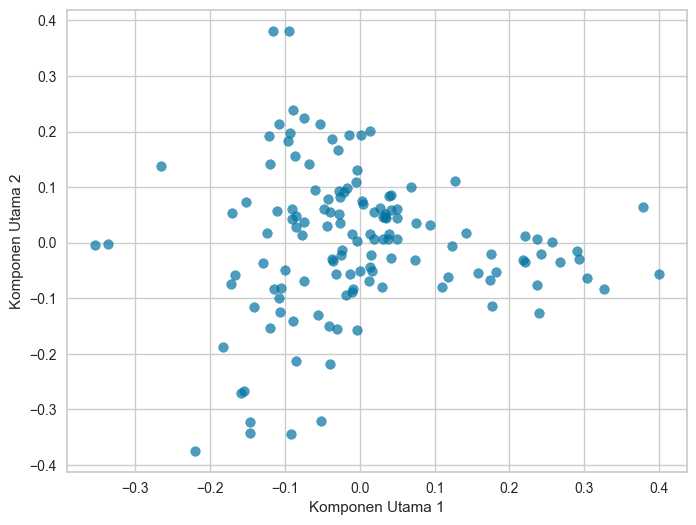

In [20]:
# Create a scatter plot of the data points in the reduced PCA space
plt.figure(figsize=(8, 6))

# Scatter the data points using the first and second principal components (dimensions)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# Label the x and y axes to indicate the principal components
plt.xlabel('1st Main Component')
plt.ylabel('2nd Main Component')

# Add a grid to the plot for better visualization
plt.grid(True)

# Display the plot
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_992\3258988852.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('cool', num_clusters)
C:\Users\HP\AppData\Local\Temp\ipykernel_992\3258988852.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Klaster {i}', c=color_palette(i))


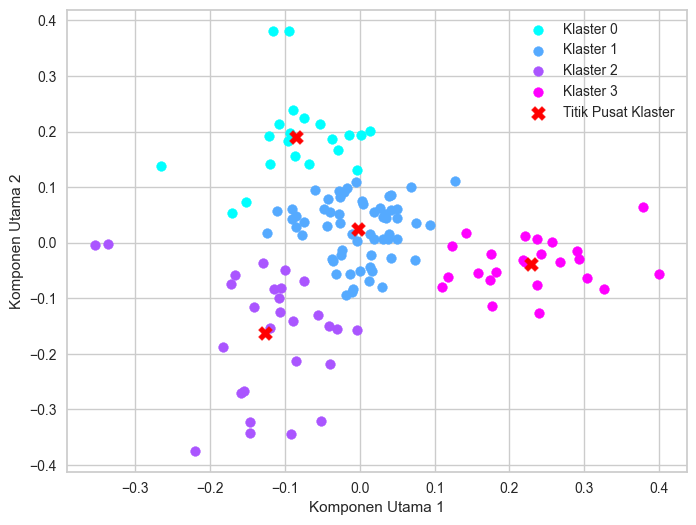

In [21]:
# Define the number of clusters for K-means
num_clusters = 4  # You've determined this number previously

# Create a K-means model with the specified number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the K-means model to the data in the reduced PCA space
kmeans.fit(X_pca)

# Get cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Transform the cluster centers to the PCA space
cluster_centers = pca.transform(kmeans.cluster_centers_)

# Create a color palette for cluster visualization
color_palette = plt.cm.get_cmap('cool', num_clusters)

# Create a scatter plot to visualize data points in different clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    # Extract data points belonging to the current cluster
    cluster_data = X_pca[cluster_labels == i]
    
    # Scatter plot for the current cluster with a unique color from the palette
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', c=color_palette(i))
    
# Scatter plot for cluster centers (marked as 'X' with red color)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red', label='Cluster Center')

# Label the x and y axes to indicate the principal components
plt.xlabel('1st Main Component')
plt.ylabel('2nd Main Component')

# Display a legend to distinguish clusters and cluster centers
plt.legend()

# Add a grid to the plot for better visualization
plt.grid(True)

# Show the plot
plt.show()

In [23]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=len(keywords_list))  
X = vectorizer.fit_transform(data)

# PCA dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Create a DataFrame to store cluster data
cluster_df = pd.DataFrame({'Text': data, 'Cluster': kmeans.labels_})

# Calculate total data points in each cluster
cluster_counts = cluster_df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Total']
cluster_df = cluster_df.merge(cluster_counts, on='Cluster')

# Save cluster data to CSV
cluster_df.to_csv('personalized_clustered.csv', index=False)

# Unigram Check & WordCloud

## Unigram Processing of Each Clusters

In [35]:
# Read the clustered data from CSV
clustered_data = pd.read_csv('personalized_clustered.csv')

# Separate data into clusters
cluster_data = [[] for _ in range(num_clusters)]
for i in range(num_clusters):
    cluster_indices = clustered_data[clustered_data['Cluster'] == i].index
    for idx in cluster_indices:
        cluster_data[i].extend(clustered_data.loc[idx, 'Text'].split())

cluster_data_unigrams = [' '.join(words) for words in cluster_data]

# Create variables for each cluster's unigrams
cluster_0_unigrams = cluster_data_unigrams[0]
cluster_1_unigrams = cluster_data_unigrams[1]
cluster_2_unigrams = cluster_data_unigrams[2]

# Display the total count of words in each cluster
for i, unigrams in enumerate(cluster_data_unigrams):
    print(f"Cluster {i} Total Unigrams: {len(unigrams.split())} Words")


Cluster 0 Total Unigrams: 1966 Words
Cluster 1 Total Unigrams: 1799 Words
Cluster 2 Total Unigrams: 1027 Words
Cluster 3 Total Unigrams: 3884 Words


In [37]:
import pandas as pd
from collections import Counter

# Read the clustered data from CSV
clustered_data = pd.read_csv('personalized_clustered.csv')

# Separate data into clusters
cluster_data = [[] for _ in range(num_clusters)]
for i in range(num_clusters):
    cluster_indices = clustered_data[clustered_data['Cluster'] == i].index
    for idx in cluster_indices:
        cluster_data[i].extend(clustered_data.loc[idx, 'Text'].split())

# Create a dictionary to store word frequencies for each cluster
word_frequencies = {}
for i, words in enumerate(cluster_data):
    word_count = Counter(words)
    sorted_word_freq = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))
    word_frequencies[f'Cluster {i}'] = sorted_word_freq

# Save word frequencies for each cluster to CSV files
for cluster, frequencies in word_frequencies.items():
    df = pd.DataFrame(frequencies.items(), columns=['Word', 'Frequency'])
    csv_filename = f'PersonalizedCSV_{cluster}.csv'
    df.to_csv(csv_filename, index=False)
    print(f"Saved {csv_filename}")

Saved PersonalizedCSV_Cluster 0.csv
Saved PersonalizedCSV_Cluster 1.csv
Saved PersonalizedCSV_Cluster 2.csv
Saved PersonalizedCSV_Cluster 3.csv


## WordCloud Visualization

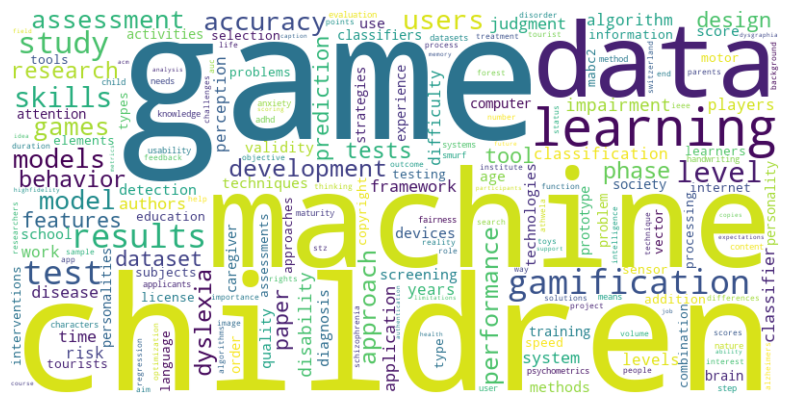

In [38]:
# 1st Cluster WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Cluster 0'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

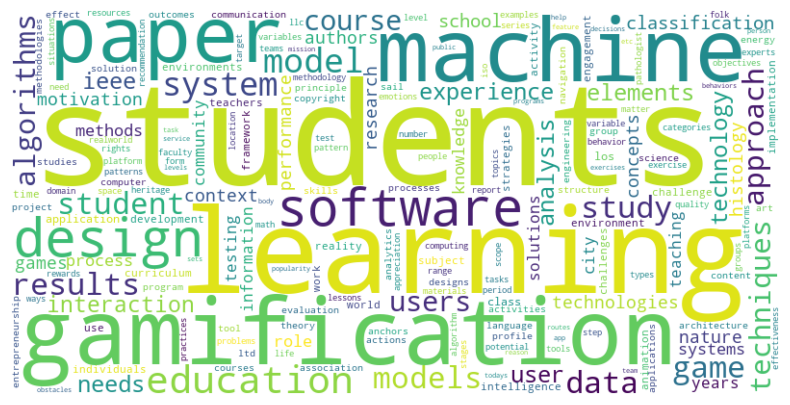

In [39]:
# 2nd Cluster WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Cluster 1'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

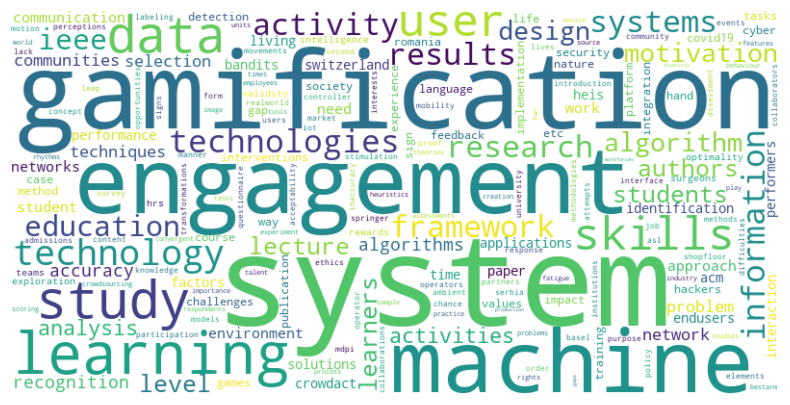

In [40]:
# 3rd Cluster WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Cluster 2'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

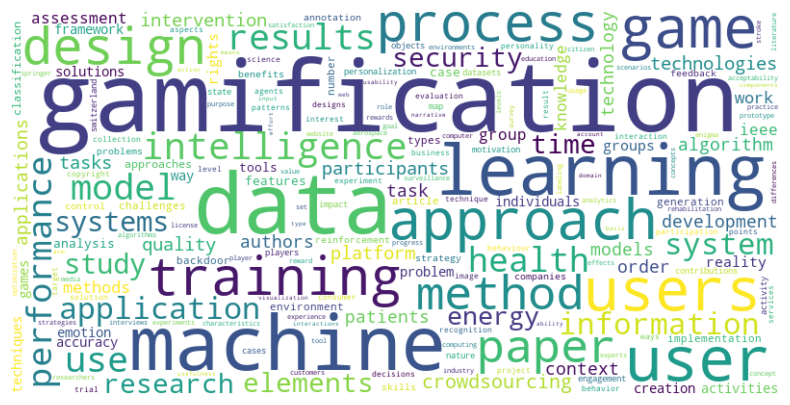

In [41]:
# 4th Cluster WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Cluster 3'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Keyword Extraction

In [34]:
# Using KeyBERT Library to Get Keyword from Each Clusters

# Initialize the KeyBERT model with a pre-trained language model
kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')

# Specify the number of clusters for K-means
num_clusters = 4

# Create a K-means model with the specified number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the K-means model to the data in the reduced PCA space and obtain cluster labels
cluster_labels = kmeans.fit_predict(X_pca)

# Create a dictionary to store texts belonging to each cluster
cluster_texts = {}

# Iterate through the data and group texts by their assigned cluster
for i, abstract_text in enumerate(data):
    cluster_label = cluster_labels[i]
    if cluster_label not in cluster_texts:
        cluster_texts[cluster_label] = []
    cluster_texts[cluster_label].append(abstract_text)

# Iterate through the clusters and extract keywords for each cluster's texts
for cluster_label, texts in cluster_texts.items():
    print(f"Cluster {cluster_label}:")
    
    # Use KeyBERT to extract keywords from the cluster's texts
    keywords = kw_model.extract_keywords(texts, keyphrase_ngram_range=(1, 2), top_n=5)
    
    # Print and display the extracted keywords for the cluster
    print(keywords, '\n')

    # Write the extracted keywords to a text file for reference
    with open(f'PerzCluster_{cluster_label}_keywords.txt', 'w') as f:
        for keyword in keywords:
            f.write(f"{keyword[0]}\n")

Cluster 2:
[[('exercise water', 0.5829), ('body exergame', 0.5749), ('exercises machine', 0.5659), ('exergame exercise', 0.5641), ('exercise interaction', 0.5572)], [('machine algorithms', 0.5931), ('dataset means', 0.5201), ('labelling task', 0.5023), ('algorithms set', 0.4972), ('labelling process', 0.4774)], [('navigation apps', 0.5443), ('users location', 0.525), ('structure navigation', 0.5242), ('location structure', 0.5127), ('app routes', 0.5124)], [('shopfloor operators', 0.5193), ('shopfloor workstations', 0.4847), ('workstations tasks', 0.467), ('operators job', 0.4496), ('workforces diversity', 0.4388)], [('trend software', 0.4852), ('software testing', 0.485), ('software tester', 0.4697), ('reason software', 0.4578), ('aspects software', 0.4502)], [('hackers skills', 0.5963), ('hackers probabilities', 0.5658), ('hackers approach', 0.5412), ('users skill', 0.5194), ('specialpurpose hackers', 0.5032)], [('usage acceptability', 0.5229), ('acceptability groups', 0.4728), ('use

*Next, we need to label each cluster manually...*